In [14]:
import sys
import os
import pandas as pd
import joblib

#for paths to more imports 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')

sys.path.append(src_path)


In [15]:

from load_data import get_data, flag_outliers_change
from strategy import geometric_dip_buyer
from backtest import run_backtest
from artifact import (
    plot_strategy_and_spy_growth,
    plot_spy_with_SMA,
    plot_relative_performance,
    plot_predictions
)
from regression import run_linear_regression, run_prediction


## load data from yfinance

In [16]:
df = get_data("SPY", interval="1d", lookback_days=500)

/Users/hockeylam/Desktop/FREBootcamp/bootcamp_hockey_lam/project/src/load_data.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


## feature engineering

In [17]:
df['change'] = df['close'].diff()
df['percent_change'] = (df['change'] / df['close'].shift(1)) * 100

## outlier detection (flagging, not removal)

In [18]:
df = flag_outliers_change(df)
outlier_count = df['change_outlier'].sum()

print(df[df['change_outlier']])
print(f"Flagged {outlier_count} outliers")

                 close        high         low        open     volume  \
datetime                                                                
2024-12-18  580.843811  600.787102  580.457413  598.379641  108248700   
2025-04-03  535.118042  546.354781  535.118042  543.503226  125986000   
2025-04-04  503.790649  524.319955  503.571297  522.126428  217965100   
2025-04-09  547.002930  547.002930  491.596716  491.985581  241867300   
2025-04-10  523.033752  531.927443  507.818723  530.601346  162331200   
2025-05-12  581.271606  581.281587  575.339132  579.756067   78993600   

               change  percent_change  change_outlier  
datetime                                               
2024-12-18 -17.842957       -2.980349            True  
2025-04-03 -27.738037       -4.928087            True  
2025-04-04 -31.327393       -5.854296            True  
2025-04-09  51.986328       10.501936            True  
2025-04-10 -23.969177       -4.381910            True  
2025-05-12  18.595032  

## feature engineering with time shifted data

In [19]:
df['30_day_SMA'] = df['close'].rolling(30).mean().shift(1)
df['30_day_volat'] = df['close'].rolling(30).std().shift(1)

# Remove first 30 rows (invalid SMA/volatility calculation)
df = df.drop(df.index[:30]).copy()
df['days_sequence'] = range(1, len(df) + 1)


## plotting with current data

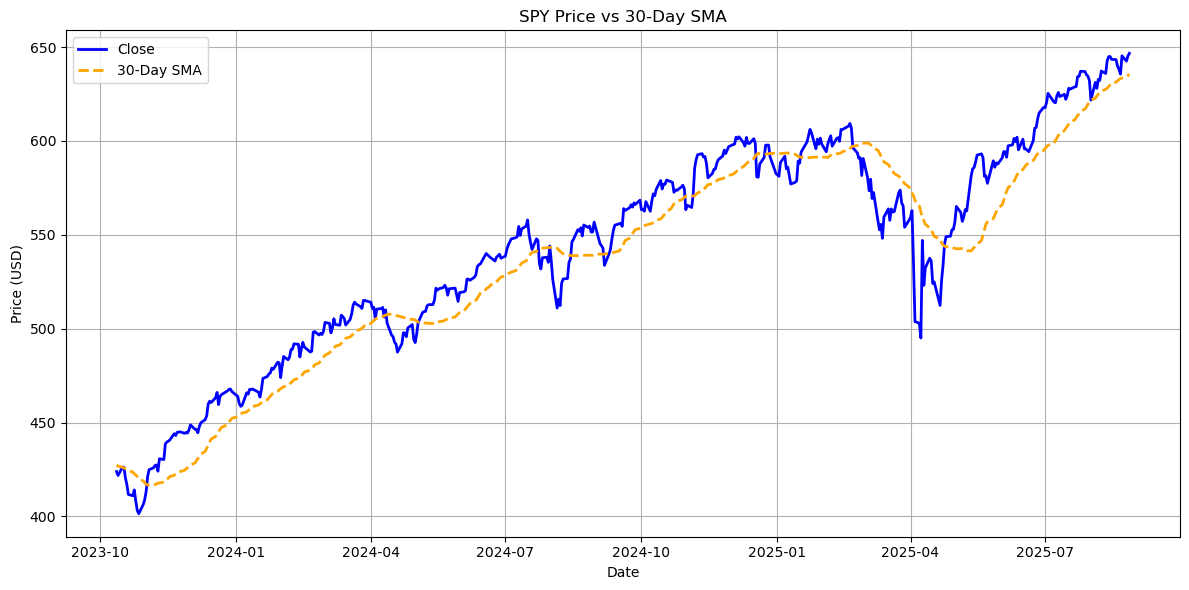

            days_sequence
datetime                 
2025-08-21            466
2025-08-22            467
2025-08-25            468
2025-08-26            469
2025-08-27            470


In [20]:
plot_spy_with_SMA(df)

pd.set_option('display.max_columns', None)
print(df.tail()[['days_sequence']])

## Run backtest with selected strategy

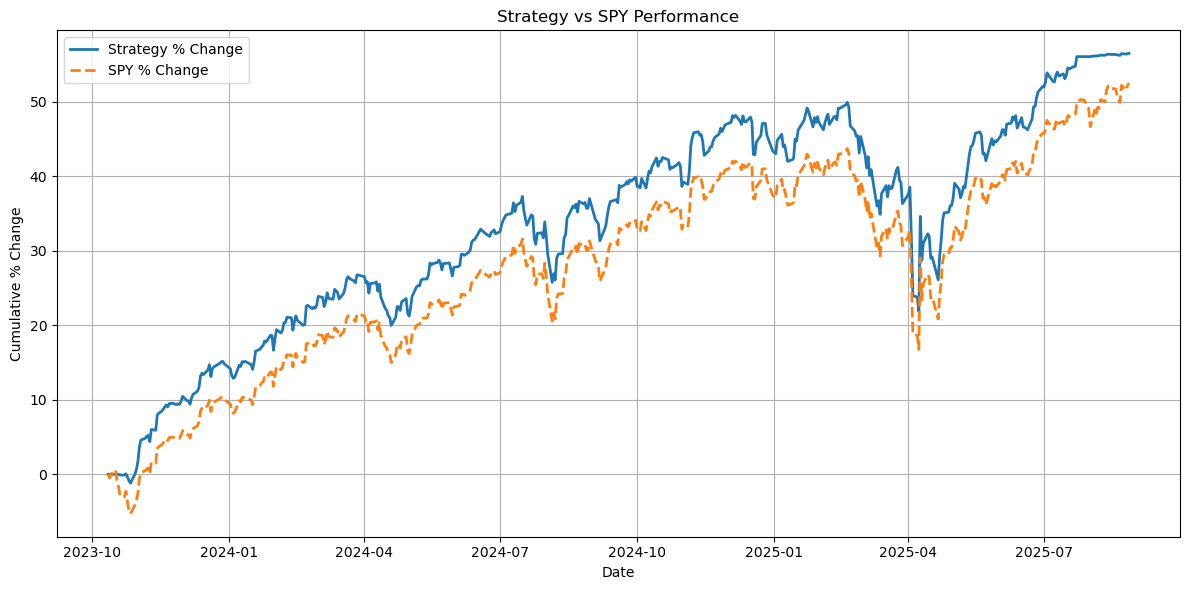

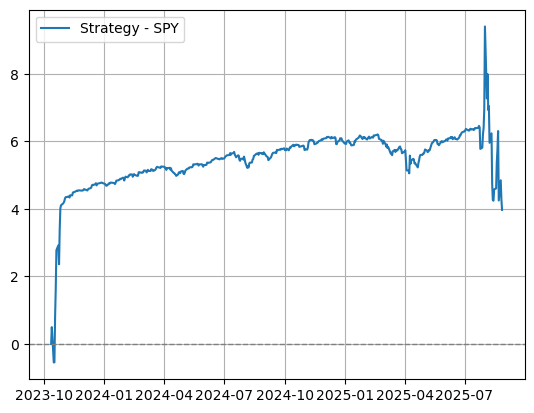

In [21]:
signals = geometric_dip_buyer(df, lookback_months=6, share_size=5, take_profit_pct=0.25)
results = run_backtest(df['close'], signals, starting_capital=100000)

plot_strategy_and_spy_growth(results, df['close'])
plot_relative_performance(results, df['close'])

## Run linear regression

MARK DOWN ASSUMPTION: Linear relation
Test R² score: 0.9890
Test Mean Squared Error: 12.9065


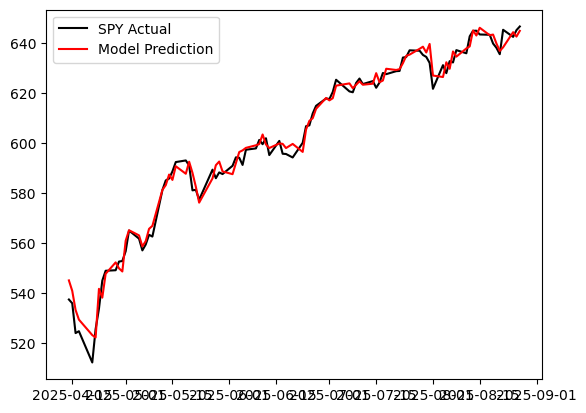

In [22]:
features = ['open', 'days_sequence']
model, y_pred = run_linear_regression(df, features=features)

plot_predictions(df, y_pred, features=features)

## Save model

In [23]:
model_dir = os.path.join(project_root, 'model')
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'linear_model.pkl')
joblib.dump(model, model_path)

['/Users/hockeylam/Desktop/FREBootcamp/bootcamp_hockey_lam/project/model/linear_model.pkl']